In [19]:

from functools import partial
from itertools import product
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from umap import UMAP
from matplotlib.patches import Patch




In [2]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [3]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [4]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [5]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [6]:
prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': Pipeline([
            ('asdense', AsDense()),
            ('clr', CLR()),
        ]),
    },
    {
        'name': 'Bray-Curtis',
        'metric': 'braycurtis',
        'pipeline': AsDense(),
    },
    {
        'name': 'Jaccard',
        'metric': 'jaccard',
        'pipeline': AsDense(),
    },
    {
        'name': 'UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree),
    },
    {
        'name': 'Weighted UniFrac',
        'metric': 'precomputed',
        'pipeline': UniFrac(tree,
                            unifrac_method='weighted_unnormalized'
                            ),
    },
]

In [7]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP, min_dist=0.5, random_state=724),
        'postprocess': postprocess_umap,
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(UMAP, min_dist=0.5, n_neighbors=80,
                            random_state=825),
        'postprocess': postprocess_umap,
    },
]

In [8]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    results[(name, method)] = {'ordination': result}


/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08975269131290495 and the largest is 10.542217394109503.
  warn(
/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/garmstro/miniconda3/envs/umap-microbiome-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metri

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}

metadata['host_surface'] = metadata['host_subject_id'] + \
                           metadata['sample_type']


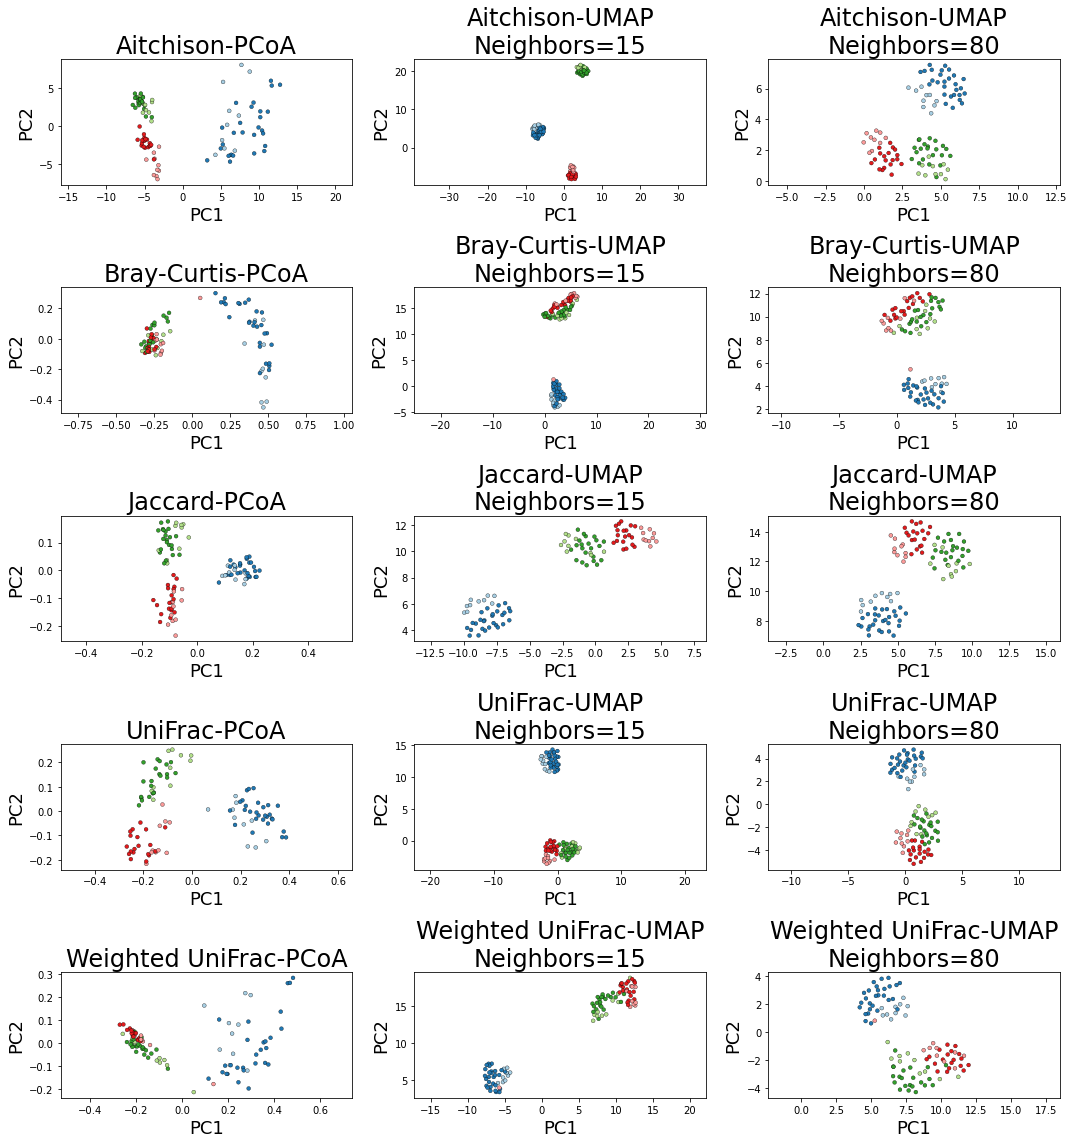

In [11]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 8 * 6 / 3),
                        )
for name, method in results:
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='host_surface',
            hue_order=list(sorted(metadata['host_surface'].unique())),
            # style='sample_type',
            data=res,
            ax=axs[i][j],
            s=15,
            edgecolor='k',
            palette='Paired',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel('PC1', color='black', fontsize=18)
        g.set_ylabel('PC2', color='black', fontsize=18),

plt.tight_layout()
plt.savefig('results/2.0-real-data-keyboard-ordination.png', dpi=300)
plt.show()

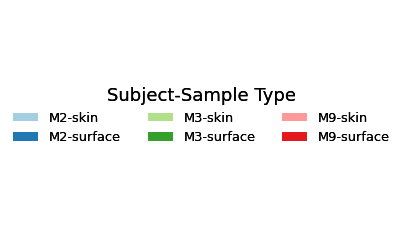

In [25]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []

    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)

    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

fig, ax = plt.subplots()
unique = list(sorted(metadata['host_surface'].unique()))
unique = [u[:2] + '-' + u[2:] for u in unique]

add_legend(ax, 'Paired', unique,
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=3, framealpha=0.0,
               title='Subject-Sample Type',
               title_fontsize=18,
           )
)
ax.axis('off')
plt.savefig('results/2.0-real-data-keyboard-ordination-legend.png', dpi=300)
plt.show()

In [ ]:
from skbio.stats.distance import permanova
from skbio import DistanceMatrix

In [13]:
def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [14]:
for (name, method), result in results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    dm_on_first_pcs = cdist(first_pcs, first_pcs)
    result['distance_matrix'] = DistanceMatrix(dm_on_first_pcs)
    # compute the permanova for the clusters
    grouping = metadata['host_subject_id']
    stats_result = permanova(result['distance_matrix'], grouping)

    result_key = 'within_subject_clustering_test'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_dm = result['distance_matrix'][:, idx][idx, :]
        stats_result = permanova(
            DistanceMatrix(sub_dm),
            sub_metadata['sample_type']
        )
        result[result_key][subject] = stats_result


In [15]:
for (name, method), result in results.items():
    result['test statistics'] = dict()
    result['test statistics']['host'] = result['within_subject_clustering_test']['overall']['test statistic']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_test'][subject]['test statistic']
        result['test statistics'][f'{subject}-type'] = stat


In [16]:
test_statistics = dict()
for (name, method), result in results.items():
    test_statistics[(name, method)] = result['test statistics']

In [17]:
pd.DataFrame(test_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.round(2)


host  M2-type  M3-type  M9-type
Aitchison        PCoA                253.46     3.26     6.32    49.00
                 UMAP Neighbors=15  4445.67    19.29    10.69    42.36
                 UMAP Neighbors=80   271.64    18.33    11.87    27.42
Bray-Curtis      PCoA                190.07    13.21     2.05     5.84
                 UMAP Neighbors=15   568.72    15.82     2.82     0.80
                 UMAP Neighbors=80   248.48    12.65     2.07     7.94
Jaccard          PCoA                422.84     4.64     2.69     4.10
                 UMAP Neighbors=15   956.61    14.51     4.98    37.93
                 UMAP Neighbors=80   342.95    15.32     6.23    24.60
UniFrac          PCoA                338.04     6.63     6.16     8.14
                 UMAP Neighbors=15  1561.88    13.06     1.26    42.84
                 UMAP Neighbors=80   366.08    14.32     5.74    32.09
Weighted UniFrac PCoA                172.91     3.57     4.58     5.03
                 UMAP Neighbors=15   600.19    13.55     1.39     2.27
                 UMAP Neighbors=80   203.16    13.60     3.64     4.48